In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np

2023-04-15 15:35:40.193241: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 15:35:40.245485: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 15:35:40.246140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 15:35:41.120729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_t = pd.read_csv('temperature.csv',index_col=0)
df_h = pd.read_csv('humidity.csv',index_col=0)
df_p = pd.read_csv('pressure.csv',index_col=0)
df_w = pd.read_csv('wind_speed.csv',index_col=0)
df_h.columns

Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')

In [3]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [4]:
city = 'San Diego'
tempog = df_t[city]
temp = df_t[city].rename("temperature").to_frame(name='temperature')
humid = df_h[city].rename("humidity").to_frame(name='humidity')
press = df_p[city].rename("presure").to_frame(name='presure')
wind = df_w[city].rename("wind").to_frame(name='wind')


features = pd.concat([temp, press, humid, wind], axis=1)
# features.index = time
features = features.dropna()
features

featuresog = features
featuresog

,temperature,presure,humidity,wind
datetime,,,,
2012-10-01 13:00:00,291.530000,1013.0,82.0,0.0
2012-10-01 14:00:00,291.533501,1013.0,81.0,0.0
2012-10-01 15:00:00,291.543355,1013.0,81.0,0.0
2012-10-01 16:00:00,291.553209,1013.0,81.0,0.0
2012-10-01 17:00:00,291.563063,1013.0,80.0,0.0
...,...,...,...,...
2017-11-29 20:00:00,292.150000,1017.0,72.0,2.0
2017-11-29 21:00:00,292.740000,1017.0,72.0,1.0
2017-11-29 22:00:00,292.580000,1016.0,68.0,2.0


In [5]:
# normalize values
features = normalize(features.values)
features = pd.DataFrame(features)
features

,0,1,2,3
0,0.222888,-0.528665,0.731908,-1.181374
1,0.223482,-0.528665,0.680392,-1.181374
2,0.225155,-0.528665,0.680392,-1.181374
3,0.226829,-0.528665,0.680392,-1.181374
4,0.228502,-0.528665,0.628876,-1.181374
...,...,...,...,...
44894,0.328173,-0.061829,0.216750,0.162904
44895,0.428364,-0.061829,0.216750,-0.509235
44896,0.401194,-0.178538,0.010687,0.162904
44897,0.406288,-0.178538,-0.246892,0.162904


In [6]:
training_size = int ( 0.8 * features.shape[0])  
train_data = features.loc[0 : training_size - 1]
val_data = features.loc[training_size:]

In [7]:
start = 432 + 36
end = start + training_size

x_train = train_data.values
y_train = features.iloc[start:end][[0]]

sequence_length = int(432 / 6)

In [8]:
from tensorflow import keras

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=x_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

2023-04-15 15:35:42.624696: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
x_val_end = len(val_data) - start

label_start = training_size + start

x_val = val_data.iloc[:x_val_end][[i for i in range(4)]].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=6,
    batch_size=64,
)

In [10]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

2023-04-15 15:35:42.796281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [35488]
	 [[{{node Placeholder/_8}}]]
2023-04-15 15:35:42.796856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [35919,4]
	 [[{{node Placeholder/_0}}]]


Model: "Weather_forcaster"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


2023-04-15 15:35:43.092559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 15:35:43.094212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 15:35:43.095578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
history = model.fit(
    dataset_train,
    epochs=15,
    validation_data=dataset_val
)

Epoch 1/15


2023-04-15 15:35:43.169638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [35488]
	 [[{{node Placeholder/_8}}]]
2023-04-15 15:35:43.170188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [35488]
	 [[{{node Placeholder/_28}}]]
2023-04-15 15:35:43.481067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

553/555 [============================>.] - ETA: 0s - loss: 0.6382

2023-04-15 15:35:54.125955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [8512,1]
	 [[{{node Placeholder/_20}}]]
2023-04-15 15:35:54.126534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8512,4]
	 [[{{node Placeholder/_0}}]]
2023-04-15 15:35:54.425309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

555/555 [==============================] - 12s 18ms/step - loss: 0.6373 - val_loss: 0.3978
Epoch 2/15
555/555 [==============================] - 10s 18ms/step - loss: 0.3734 - val_loss: 0.3071
Epoch 3/15
555/555 [==============================] - 10s 18ms/step - loss: 0.3117 - val_loss: 0.2480
Epoch 4/15
555/555 [==============================] - 10s 18ms/step - loss: 0.2903 - val_loss: 0.2226
Epoch 5/15
555/555 [==============================] - 10s 18ms/step - loss: 0.2773 - val_loss: 0.2141
Epoch 6/15
555/555 [==============================] - 10s 18ms/step - loss: 0.2695 - val_loss: 0.2117
Epoch 7/15
555/555 [==============================] - 10s 18ms/step - loss: 0.2616 - val_loss: 0.2111
Epoch 8/15
555/555 [==============================] - 10s 17ms/step - loss: 0.2583 - val_loss: 0.2141
Epoch 9/15
555/555 [==============================] - 10s 18ms/step - loss: 0.2565 - val_loss: 0.2183
Epoch 10/15
555/555 [==============================] - 10s 18ms/step - loss: 0.2529 - val_los

datetime
2012-10-01 12:00:00           NaN
2012-10-01 13:00:00    291.530000
2012-10-01 14:00:00    291.533501
2012-10-01 15:00:00    291.543355
2012-10-01 16:00:00    291.553209
                          ...    
2017-11-29 20:00:00    292.150000
2017-11-29 21:00:00    292.740000
2017-11-29 22:00:00    292.580000
2017-11-29 23:00:00    292.610000
2017-11-30 00:00:00    291.400000
Name: temperature, Length: 45253, dtype: float64


2023-04-15 15:38:12.519756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [8081]
	 [[{{node Placeholder/_28}}]]
2023-04-15 15:38:12.520343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8512,4]
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 6ms/step


2023-04-15 15:38:12.852985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 15:38:12.854553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 15:38:12.855872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

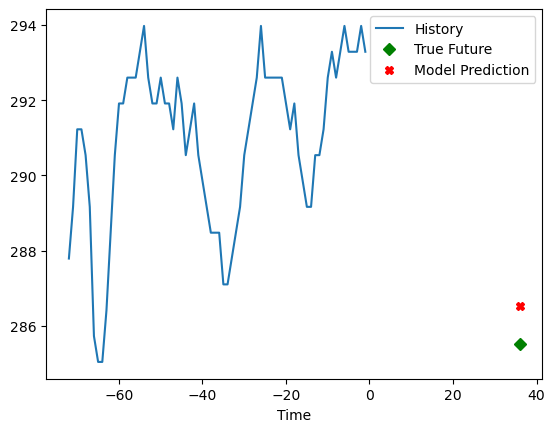

In [12]:
import matplotlib.pyplot as plt

temperature=temp.squeeze()
print(temperature)
temp_mean = temperature.mean(axis=0)
temp_std = temperature.std(axis=0)

for x, y in dataset_val.skip(12):
    history_data = x[0][:, 1].numpy() * temp_std + temp_mean
    true_value = y[0].numpy() * temp_std + temp_mean
    prediction = model.predict(x)[0] * temp_std + temp_mean
    time_steps = list(range(-(history_data.shape[0]), 0))
    plt.plot(time_steps, history_data)
    plt.plot(36, true_value, "gD")
    plt.plot(36, prediction, "rX")
    plt.legend(["History", "True Future", "Model Prediction"])
    plt.xlabel("Time")
    plt.show()
    break

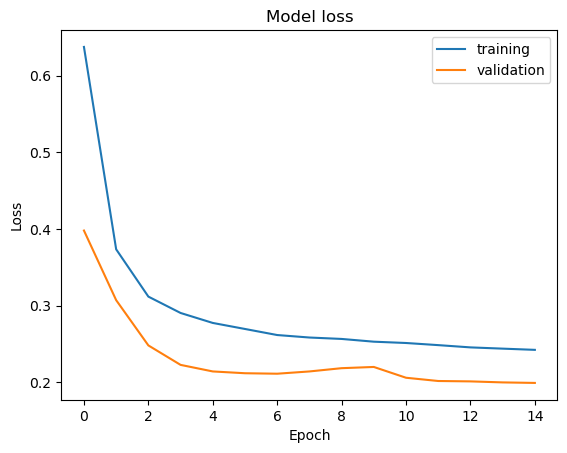

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [14]:
# ighnore below
dataset = featuresog.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(features.columns)
print('Number of features', num_of_features)


Number of features 4


In [15]:
look_back = sequence_length

In [16]:


train_size_percent = 0.80
pred_col = featuresog.columns.get_loc("temperature")
print(pred_col)

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

0
Training dataset length  35919
Testing dataset length  8980
look_back  72


In [17]:
expr_name = 'expr_4'
# look_back = 24*120 # 60 days, as each entry is for 1 hour
lstm_layers = 64 # 64
epochs=6 # 6
batch_size=128 #128

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/6


2023-04-15 15:38:13.661981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 15:38:13.663551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 15:38:13.664853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

195/197 [============================>.] - ETA: 0s - loss: 0.0169

2023-04-15 15:38:22.016982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 15:38:22.018642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 15:38:22.019975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

197/197 [==============================] - 10s 38ms/step - loss: 0.0168 - val_loss: 0.0153
Epoch 2/6
197/197 [==============================] - 7s 37ms/step - loss: 0.0037 - val_loss: 0.0074
Epoch 3/6
197/197 [==============================] - 7s 36ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 4/6
197/197 [==============================] - 7s 36ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/6
197/197 [==============================] - 7s 36ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 6/6
197/197 [==============================] - 7s 35ms/step - loss: 0.0012 - val_loss: 0.0020


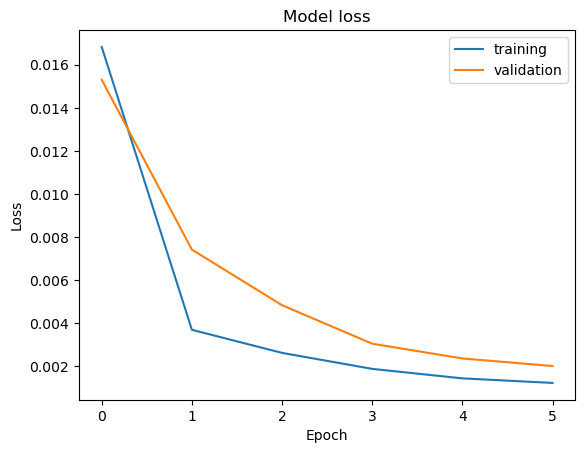

In [18]:
# plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

   9/1121 [..............................] - ETA: 7s  

2023-04-15 15:38:59.079022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-15 15:38:59.080638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-15 15:38:59.081937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

279/279 [==============================] - 2s 7ms/step


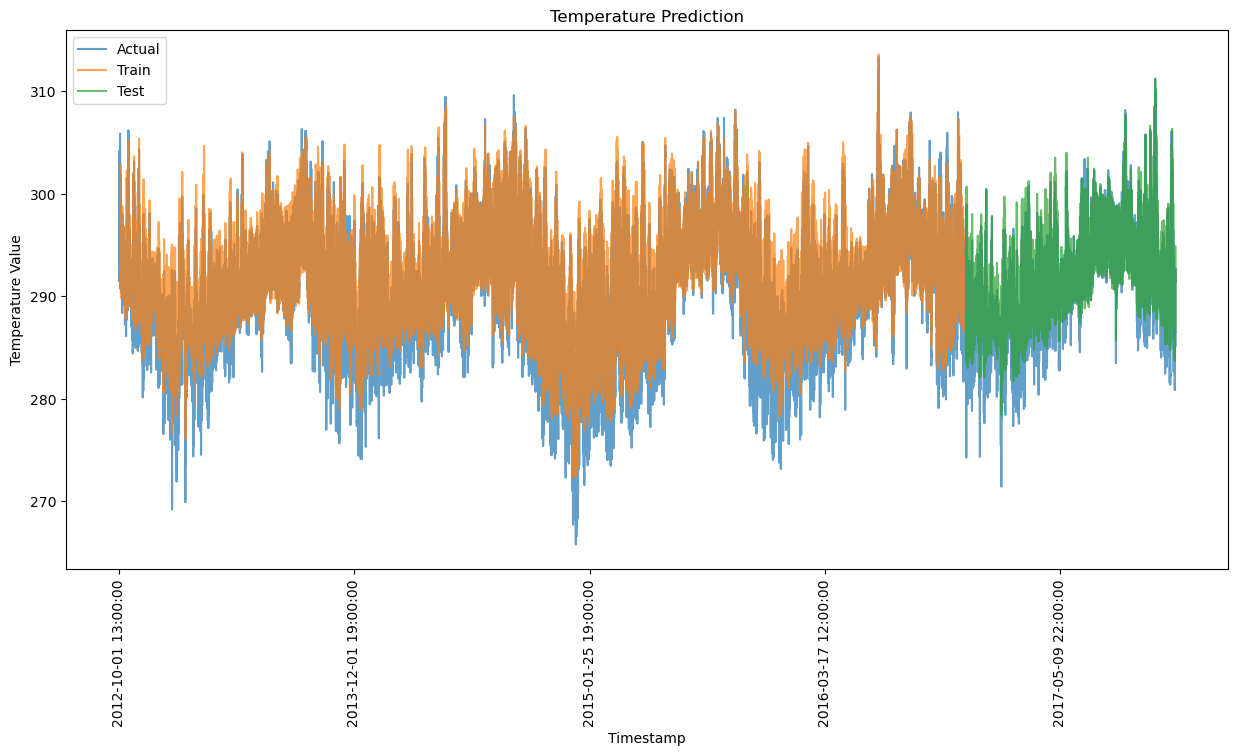

In [19]:
import math
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(featuresog.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)

# print(time_df2)

time_df2.set_index('datetime',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature Value')
plt.title('Temperature Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")


In [20]:
print(trainScore_RMSE)
print(testScore_RMSE)

2.3064599721245567
1.8449628531177384


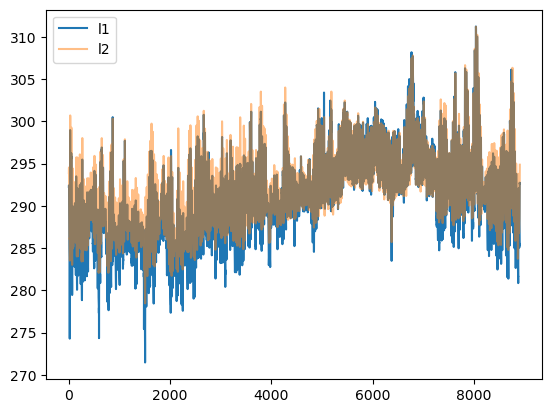

In [21]:
plt.plot(range(0,len(testY)),testY,label='l1')
plt.plot(range(0,len(testPredict)),testPredict,label='l2',alpha=.5)
plt.legend()
plt.show()

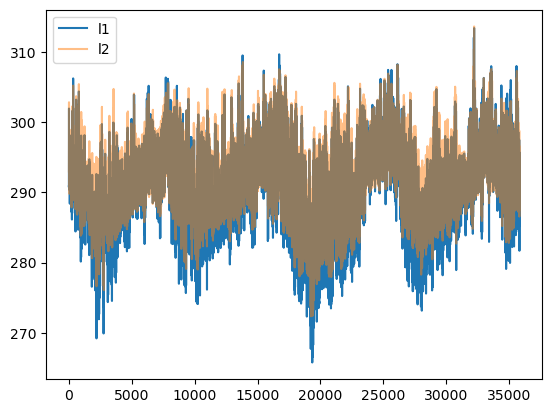

In [22]:
plt.plot(range(0,len(trainY)),trainY,label='l1')
plt.plot(range(0,len(trainPredict)),trainPredict,label='l2',alpha=.5)
plt.legend()
plt.show()